In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.utils import resample
from IPython.display import display, Math, Latex
import scipy.stats as stats

# 1)

In [185]:
n = 50
p = 6
alpha = 0.05

Psi = np.concat([np.ones((n, 1)), np.random.uniform(-1, 1, (n, 5))], axis=1)
Y = np.array([np.random.normal(np.array([2, 3, -2, 1, 1, -1]) @ xi, 1.5) for xi in Psi])

## a)

In [186]:
def r_sq(psi, y):
    F = psi.T @ psi
    F_inv = np.linalg.inv(F)
    beta = F_inv @ psi.T @ y
    RSS = np.sum((y - psi @ beta) ** 2)
    TSS = np.sum((y - np.mean(y)) ** 2)
    return (TSS - RSS) / TSS
    
for i in range(5):
    mask = np.zeros(6, dtype=bool)
    mask[i + 1] = 1
    R_sq = r_sq(Psi[:, ~mask], Psi[:, mask])
    display(Math(r"R^2_{i}={R_sq}".format(i=i+1, R_sq=R_sq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

все $R^2 < 0.7 \ \Rightarrow$ мультиколлинеарности нет

## b)

In [ ]:
F = Psi.T @ Psi
F_inv = np.linalg.inv(F)
beta = F_inv @ Psi.T @ Y
RSS = np.sum((Y - Psi @ beta) ** 2)

beta_p_val = []

for i in range(p):
    delta = beta[i] / np.sqrt(RSS * F_inv[i, i]) * np.sqrt(n - p)
    p_val = 2 * stats.t.sf(abs(delta), n - p)
    beta_p_val.append(p_val)
    matter = "значим" if p_val < alpha else "не значим"
    display(Latex(r"$\beta_{i}$: p-value $={p_val}$, ".format(i=i+1,p_val=p_val)+matter))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## c)

In [188]:
RSS = np.sum((Y - Psi @ beta) ** 2)
TSS = np.sum((Y - np.mean(Y)) ** 2)

R_sq = (TSS - RSS) / TSS 
display(Math(r"R^2={R_sq}".format(R_sq = R_sq)))

delta = ((TSS - RSS) * (n - p)) / (RSS * (p - 1))
p_val = stats.f.cdf(-abs(delta), p - 1, n - p) + stats.f.sf(abs(delta), p - 1, n - p)
matter = "значим" if p_val < alpha else "не значим"
display(Latex(r"p-value $={p_val}$, ".format(p_val = p_val) + matter))


<IPython.core.display.Math object>

<IPython.core.display.Latex object>

## d)

In [189]:
x0 = np.array([1, 0, 0, 0, 0, 0])
y_est = x0 @ beta
delta = stats.t.isf(0.025, n - p) * np.sqrt((1 + x0 @ F_inv @ x0.T) * (RSS / (n - p)))
display(Math(r"y={y:.4f}".format(y=y_est)))
display(Math(r"I=({l:.4f},{r:.4f})".format(l=y_est - delta, r=y_est + delta)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## e)

In [190]:
def inversions(arr):
    inv = 0
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            if arr[i] > arr[j]:
                inv += 1
    return inv


e = Y - Psi @ beta
delta = float((inversions(e) - n * (n - 1) / 4) / np.sqrt(n ** 3 / 36))
p_val = 2 * stats.norm.sf(delta)
matter = "ошибки" + " независимы" if p_val > alpha else "зависимы"
display(Latex(f"p-value $={p_val:.4f}$, " + matter))

<IPython.core.display.Latex object>

## f)

In [191]:
bs_n = 50000

e = Y - Psi @ beta
std = np.std(e)

bs_data = np.ndarray((bs_n,), dtype=np.float32)
for i in range(bs_n):
    sample = np.random.normal(0, std, n)
    sample = np.sort(sample)
    sample_std = np.std(sample)
    
    ecdf = np.append([0], stats.ecdf(sample).cdf.probabilities)
    cdf = stats.norm.cdf(sample, loc=0, scale=sample_std)
    delta = np.sqrt(n) * np.max(np.abs(
        np.append(
            cdf - ecdf[:len(ecdf) - 1],
            cdf - ecdf[1:]
        )
    ))
    bs_data[i] = delta
bs_data = np.sort(bs_data)

ecdf = np.append([0], stats.ecdf(e).cdf.probabilities)
cdf = stats.norm.cdf(np.sort(e), loc=0, scale=std)
k_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:len(ecdf) - 1],
        cdf - ecdf[1:]
    )
))

k_p_val = np.count_nonzero(bs_data >= k_delta) / bs_n

display(Latex(f"p-value $={k_p_val}$"))


<IPython.core.display.Latex object>

$\Rightarrow$ ошибки распределены нормально

## g)

Text(0.5, 1.0, 'y')

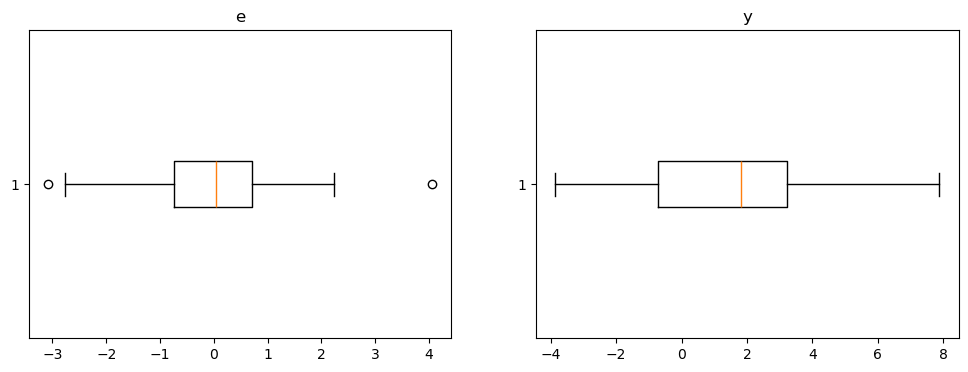

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].boxplot(e, orientation="horizontal")
ax[0].set_title('e')

ax[1].boxplot(Y, orientation="horizontal")
ax[1].set_title('y')

## h)

In [193]:
def find_beta(psi, y):
    F = psi.T @ psi
    F_inv = np.linalg.inv(F)
    return F_inv, F_inv @ psi.T @ y

CVSS = 0

for i in range(n):
    mask = np.ones(n, dtype=bool)
    mask[i] = 0
    _, beta = find_beta(Psi[mask], Y[mask])
    CVSS += (Y[i] - beta @ Psi[i]) ** 2

R_sq_cv = (TSS - CVSS) / TSS
display(Math(r"R_{{CV}}^2={R_sq:.4f}".format(R_sq=R_sq_cv)))

<IPython.core.display.Math object>

## i)

In [194]:
l = 5
psi = np.concat([np.ones(1), np.random.uniform(-1, 1, 5)])
y = np.array([np.random.normal(
        np.array([2, 3, -2, 1, 1, -1]) @ psi, 1.5
    ) for _ in range(l)])
delta = float(RSS / (n - p) / np.std(y) ** 2)
p_val = stats.f.cdf(-abs(delta), n-p, l - 1) + stats.f.sf(abs(delta), n - p, l - 1)
matter = "адекватна" if p_val > alpha else "неадеватна"
display(Latex(f"p-value $={p_val:.4f}$, регрессия " +matter))

<IPython.core.display.Latex object>

## j)

In [195]:
out = np.argmin(np.abs(beta))
print(f"Выкидываем {out+1}")
mask = np.ones(p, dtype=bool)
mask[out] = 0
psi_s = Psi[:, mask]
f_inv_s, beta_s = find_beta(psi_s, Y)
rss_s = np.sum((Y - psi_s @ beta_s) ** 2)

Выкидываем 4


In [196]:
for i in range(p-1):
    delta = beta_s[i] / np.sqrt(rss_s * f_inv_s[i, i]) * np.sqrt(n - p + 1)
    p_val = 2 * stats.t.sf(abs(delta), n - p + 1)
    matter = "значим" if p_val < alpha else "не значим"
    display(Latex(r"$\beta_{i}$: p-value $={p_val}$, ".format(i=i+1,p_val=p_val)+matter))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [197]:
tss_s = np.sum((Y - np.mean(Y)) ** 2)

R_sq_s = (tss_s - rss_s) / tss_s 
display(Math(r"R^2={R_sq}".format(R_sq = R_sq_s)))

delta = ((tss_s - rss_s) * (n - p + 1)) / (rss_s * (p - 2))
p_val = stats.f.cdf(-abs(delta), p - 2, n - p + 1) + stats.f.sf(abs(delta), p - 2, n - p + 1)
matter = "значим" if p_val < alpha else "не значим"
display(Latex(r"p-value $={p_val}$, ".format(p_val = p_val) + matter))

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

In [198]:
delta = (rss_s - RSS) / (RSS / (n - p))
p_val = stats.f.cdf(-abs(delta), 1, n - p) + stats.f.sf(abs(delta), 1, n - p)
matter = "длинная лучше" if p_val < alpha else "короткая лучше"
display(Latex(r"p-value $={p_val}$, ".format(p_val = p_val) + matter))

<IPython.core.display.Latex object>

## k)

In [199]:
h = R_sq - R_sq_s

def find_r_sq(psi, y):
    _, beta = find_beta(psi, y)
    rss = np.sum((y - psi @ beta) ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    return (tss - rss) / tss

def delta(sample):
    psi = sample[:, :len(sample[0]) - 1]
    y = sample[:, -1]
    psi_s = psi[:, mask]
    return (find_r_sq(psi, y) - find_r_sq(psi_s, y)) - h

data = np.concatenate([Psi, Y[:, np.newaxis]], axis=1)
res = []
n_resamples = 1000
for _ in range(n_resamples):
    sample = resample(data, replace=True, n_samples=n)
    res.append(delta(sample))
res = sorted(res)
I = (h - res[n_resamples - 1], h - res[int(alpha * n_resamples) - 1])
display(Math(f"I=({I[0]:.4f},{I[1]:.4f})"))

<IPython.core.display.Math object>

# 2)

In [200]:
data = [
    [83, 85],
    [84, 85, 85, 86, 86, 87],
    [86, 87, 87, 87, 88, 88, 88, 88, 88, 89, 90],
    [89, 90, 90, 91],
    [90, 92]
]
alpha = 0.05

Y = np.concat(data).flatten()
N= Y.size
n_g = len(data)

## a)

In [201]:
Psi = np.zeros((N, n_g), dtype=int)

row = 0
for i in range(n_g):
    g_l = len(data[i])
    Psi[row:row + g_l, i] = 1
    row += g_l

F = Psi.T @ Psi
F_inv = np.linalg.inv(F)
beta = F_inv @ Psi.T @ Y
e = Y - (Psi @ beta)
RSS = (e.T @ e)
TSS = sum((y - Y.mean()) ** 2 for y in Y)
R_sq = (TSS - RSS) / TSS

display(Math(r'R^2={R_sq:.2f}'.format(R_sq=R_sq)))

<IPython.core.display.Math object>

In [202]:
delta = float(((TSS - RSS) * (N-n_g)) / (RSS * (4)))
p_val = float(stats.f.sf(delta, 4, 20) + stats.f.cdf(-delta, 4, 20))
display(Latex(r"p-value={p_val}".format(p_val=p_val)))


<IPython.core.display.Latex object>

$ \Rightarrow$ регрессия значима

### Проверка значимости коэффициентов:
$$ H_0: \beta_i = 0 \qquad H_1: \beta_i \neq 0 $$

In [203]:
for i in range(len(beta)):
    delta = (beta[i] * np.sqrt(N - n_g)) / np.sqrt(RSS * F_inv[i][i])
    display(Latex(r"p-value $_{i}={pv}$".format(i = i + 1, pv = 2 * stats.t.sf(delta, N - n_g))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$\Rightarrow$ все коэффициенты значимы

## b)

### Проверка равенства средних:
$$ H_0: \beta_i = \beta_j \qquad H_1: \beta_i \neq \beta_j $$

In [204]:
p_vals = []
for i in range(len(beta)):
    for j in range(i + 1, len(beta)):
        delta = (beta[i] - beta[j]) / ((RSS * (F_inv[i][i] + F_inv[j][j])) ** 0.5)
        p_val = 2 * stats.t.sf(abs(delta), N - n_g)
        display(Latex(r"p-value $_{{{ij}}}={pv:.4f}$".format(ij = f"{i+1}{j+1}", pv = p_val)))
        p_vals.append(p_val)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$\Rightarrow$ все коэффициенты равны

### Холм-Бонферрони:

In [205]:
m = len(p_vals)
p_vals = np.array(p_vals)
ind = np.argsort(p_vals)
k=0
for i in range(len(beta)):
    for j in range(i+1, len(beta)):
        m_i = m - np.argwhere(ind == k)[0][0]
        alpha_i = alpha / (m_i)
        p_val = p_vals[k]
        display(Latex(r'p-value $_{{{ij}}}={pv:.4f}; \; \alpha/{m_i}={a_i:.4f}$'.format(ij=f"{i+1}{j+1}", pv=p_val, m_i = m_i, a_i = alpha_i)))
        k += 1

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$\Rightarrow$ все коэффициенты равны

# 3)

In [206]:
Psi = np.array([[1, 0], [0,1], [1,1]])
Y = np.array([[1], [5], [2]])

## a)

In [207]:
F = Psi.T @ Psi
F_inv = np.linalg.inv(F)
beta = F_inv @ Psi.T @ Y 
display(Math(r'\omega={a:.2f}\varepsilon + {b:.2f}\eta'.format(a=beta[0,0], b=beta[1,0])))

<IPython.core.display.Math object>

## b)

Оптимальный параметр регуляризации:


<IPython.core.display.Math object>

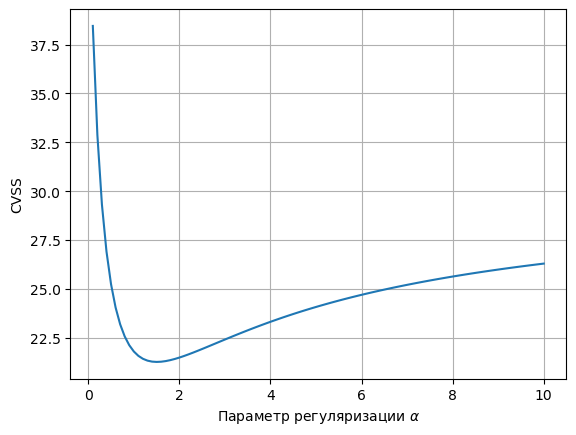

In [208]:

def find_CVSS_ridge(Psi, Y, a):
    CVSS = 0
    n = Y.shape[0]
    for i in range(n):
        mask = np.ones(n, dtype=bool)
        mask[i]= False
        beta = Ridge(alpha = a, fit_intercept=False).fit(Psi[mask], Y[mask]).coef_
        y_pred = Psi[i] @ beta
        CVSS += np.square(Y[i] - y_pred)
    return CVSS

alpha = np.linspace(0.1, 10, num=100)
CVSS = np.array([find_CVSS_ridge(Psi, Y, a) for a in alpha])

print("Оптимальный параметр регуляризации:")
display(Math(r'\alpha={a}'.format(a=alpha[np.argmin(CVSS)])))
fig, ax = plt.subplots(1, 1)
ax.plot(alpha, CVSS)
ax.set_ylabel("CVSS")
ax.set_xlabel(r"Параметр регуляризации $\alpha$")
ax.grid()

Оптимальный параметр регуляризации:


<IPython.core.display.Math object>

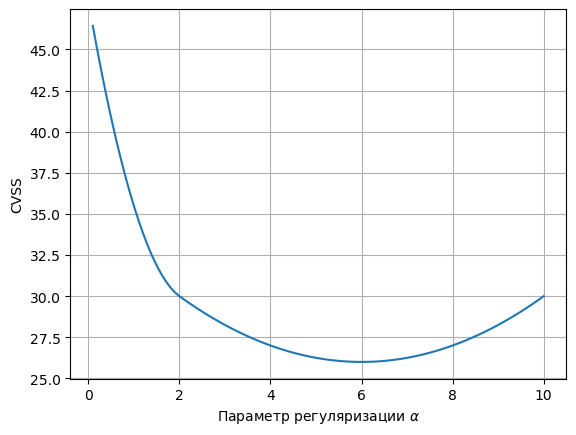

In [209]:
def find_CVSS_lasso(Psi, Y, a):
    CVSS = 0
    n = Y.shape[0]
    for i in range(n):
        mask = np.ones(n, dtype=bool)
        mask[i]= False
        beta = Lasso(alpha = a / 4, fit_intercept=False).fit(Psi[mask], Y[mask]).coef_
        y_pred = Psi[i] @ beta
        CVSS += np.square(Y[i] - y_pred)
    return CVSS

alpha = np.linspace(0.1, 10, num=100)
CVSS = np.array([find_CVSS_lasso(Psi, Y, a) for a in alpha])

print("Оптимальный параметр регуляризации:")
display(Math(r'\alpha={a}'.format(a=alpha[np.argmin(CVSS)])))
fig, ax = plt.subplots(1, 1)
ax.plot(alpha, CVSS)
ax.set_ylabel("CVSS")
ax.set_xlabel(r"Параметр регуляризации $\alpha$")
ax.grid()